# Implementing Naive Bayes algorithm to classify spam/non-spam emails

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson

In [3]:
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

In [4]:
y.columns = ['y']

In [5]:
data = pd.concat([X,y],axis=1)

In [6]:
data.isnull().values.any()

False

In [7]:
s_data = data.sample(frac=1).reset_index(drop=True)

In [8]:
s_data.isnull().values.any()

False

In [9]:
cv_groups = []
s = 0
for i in range(1,11):
    e = s + 460
    inter = s_data.iloc[s:e,:]
    cv_groups.append(inter)
    s = e

In [10]:
import math

def bayes(c_matrix):
    
    l0_54 = []
    l1_54 = []

    for i in range(0,10):
        cv_g = cv_groups.copy()
        hold_out = cv_g[i]
        del cv_g[i]
        train = pd.concat(cv_g)
        train.index = range(len(train.index))
        ypred = []
        test_rows = len(hold_out.index)
        train_rows = len(train.index)
        
        # calculate pi
        pi_1 = math.log(train.iloc[:,-1].sum()/len(train.index))
        pi_0 = math.log(1 - pi_1)
        
        y_test = hold_out.iloc[:,-1]
        hold_out = hold_out.iloc[:,:-1]
        
        # calculate the sum of xi over each dimension for y=0,1
        cols = []
        for i in range(0,54):
            cols.append(i)
        train.groupby(['y'])[cols].sum()
        x0d = train.groupby(['y'])[cols].sum().loc[0.0]
        x1d = train.groupby(['y'])[cols].sum().loc[1.0]

        # calculate lambda for each dimension for y = 0,1
        l0 = []
        l1 = []
        for i in range(0,54):
            l0.append((1 + x0d[i])/(1 + train.groupby(['y'])['y'].count()[0]))
            l1.append((1 + x1d[i])/(1 + train.groupby(['y'])['y'].count()[1]))
        
        # append l0 and l1 to the respective parent lists
        l0_54.append(l0)
        l1_54.append(l1)
        
        # iterate through every test data point
        for hind, hrow in hold_out.iterrows():
            poisson_0 = 0
            poisson_1 = 0
            
            # iterate through every dimension of a data point
            for index, element in hrow.iteritems():
                
                  poisson_0 = poisson_0 -l0[index] + (element * math.log(l0[index]))
                  poisson_1 = poisson_1 -l1[index] + (element * math.log(l1[index]))
            
            # check the one that has highest probability and predict y
            y0 = pi_0 + (poisson_0)
            y1 = pi_1 + (poisson_1)

            if (y0 > y1):
                ypred.append(0)
            else:
                ypred.append(1)
        
        # find model accuracy
        tp = 0
        tn = 0
        fp = 0
        fn = 0
        
        for u,v in zip(list(y_test),ypred):
            
            if (int(u)==v==0):
                tn += 1
            if (int(u)==v==1):
                tp += 1
            if ((int(u) == 0) & (v == 1)):
                fp += 1
            if ((int(u) == 1) & (v == 0)):
                fn += 1

        c_matrix_inter = np.array([[tp, fp],[fn, tn]])
        c_matrix = np.add(c_matrix, c_matrix_inter)
    return c_matrix, l0_54, l1_54

c_matrix_init = np.array([[0,0],[0,0]])
c_matrix, l0_54, l1_54 = bayes(c_matrix_init)

In [11]:
print("Confusion matrix")
print(c_matrix)

Confusion matrix
[[1709  481]
 [ 104 2306]]


In [12]:
accuracy = (c_matrix[0][0] + c_matrix[1][1])/4600
print("Accuracy: " + str(accuracy*100))

Accuracy: 87.28260869565217


In [13]:
l0_54_df = pd.DataFrame(l0_54)
l1_54_df = pd.DataFrame(l1_54)

Text(0.5, 1.0, 'stem plot of features Vs lambda')

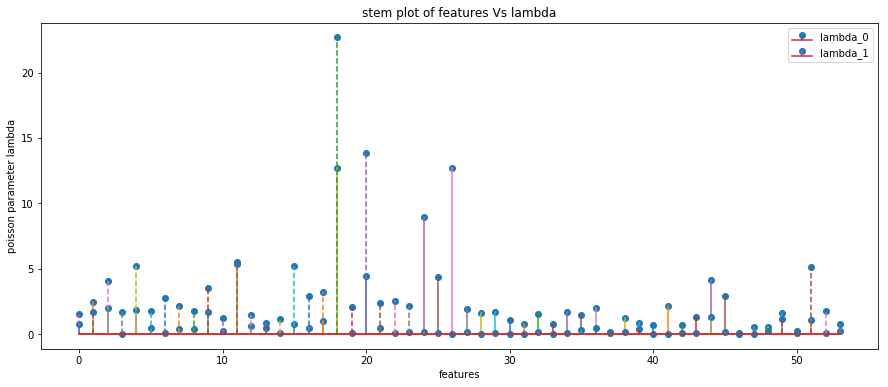

In [14]:
l0_54_mean = list(l0_54_df.mean(axis=0))
l1_54_mean = list(l1_54_df.mean(axis=0))
plt.figure(figsize=(15,6))
plt.stem(l0_54_mean,linefmt='-',label='lambda_0')
plt.stem(l1_54_mean,linefmt='--',label='lambda_1')
plt.legend()
plt.xlabel("features")
plt.ylabel("poisson parameter lambda")
plt.title("stem plot of features Vs lambda")

The dashed line in the above plot represents lambda value for spam emails. Solid lines represent nonspam emails. It can be seen that it is significantly more likely to find the words “Free” and “!” in a spammed email rather than non-spam email. Lambda is the mean value of poisson distribution. Each of the above dimensions fall under poisson distribution with means/ rate of occurrence as shown above. 